In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
from libpysal.graph import read_parquet, Graph
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import preprocess_clustering_data
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
from scipy.cluster.hierarchy import fcluster
from core.utils import used_keys

In [10]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_75_0_None_None_False'
clip = None
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
          # 'licBAD',
    # 'misBAD',
    # 'ssbCCM','ssbCCD'    
]


linkage = 'complete'
metric = 'euclidean'

morphotope_stat_columns = ['percentile_25', 'percentile_75', 'mean', 'std']

In [11]:
def preprocess_data(data, scalar, drop_columns=morphotope_stat_columns):
    component_data = data.drop(columns=drop_columns, level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  component_data.columns.get_level_values(0)
    
    component_data = component_data[component_data.index.str[-2:] != '-1']
    
    vals = scalar.fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)
    
    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id, scalar):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data, scalar)

    return component_data

def get_morphotope_linkage(region_data):
    
    clusterer = AgglomerativeClustering(linkage=linkage,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def get_all_clusters(cutoff):
    
    all_clusters = []
    
    for region_id, _ in region_hulls.iterrows():
        data = read_region_morphotope_data(region_id, scalar=StandardScaler())
        region_index = data.index
        linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}.npy')
        clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
        clusters = pd.Series(clusters, region_index).astype(str)
        clusters = str(region_id) + '_' +clusters
        all_clusters.append(clusters)
    
    all_clusters = pd.concat(all_clusters)
    
    return all_clusters


def read_morphotopes_data(model_params):
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
        region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
        data.append(region_morphotope_data)
    
    data = pd.concat(data)
    return data

def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [12]:
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

In [13]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
scalar = QuantileTransformer(subsample=None, output_distribution='uniform')


In [14]:
# %%time

# ## generate and save linkage matricies for each region
# for region_id, _ in region_hulls.iterrows():
#     data = read_region_morphotope_data(region_id, scalar)
#     linkage_matrix = get_morphotope_linkage(data)
#     np.save(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}', linkage_matrix)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (184). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (96). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (297). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (635). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (182). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (201). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (342). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (257). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (68). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (591). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (109). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (484). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (94). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (931). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (257). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (271). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (202). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (127). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (162). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (152). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (217). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (286). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 3752
processing 3759
processing 3981
processing 4070
processing 4214


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (114). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (314). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (157). n_quantiles is set to n_samples.
  warnings.warn(


processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (501). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (64). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (176). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (907). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (234). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (153). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 5671
processing 5766
processing 5883
processing 6254
processing 6529
processing 6560


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (470). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (710). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (453). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (169). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 6576
processing 6741
processing 6749
processing 6811
processing 6873
processing 6996
processing 7068
processing 7094
processing 7280


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (137). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (53). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (401). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 7485
processing 7528
processing 7534
processing 7681
processing 7688
processing 7712
processing 7727


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (76). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (502). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (215). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 7805
processing 7914
processing 7937
processing 7963
processing 8046
processing 8216


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (320). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (130). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (350). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (452). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 8238
processing 8256
processing 8265
processing 8345
processing 8374
processing 8396
processing 8592
processing 8707


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (183). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (71). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (232). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 8731
processing 8757
processing 8759
processing 8813
processing 9016
processing 9064
processing 9074
processing 9150


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (442). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (250). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (220). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (184). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 9169
processing 9194
processing 9284
processing 9824
processing 9924
processing 9954


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (891). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (193). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (94). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 9972
processing 10019
processing 10086
processing 10095
processing 10124


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (175). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (84). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (222). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (150). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 10179
processing 10222
processing 10263
processing 10277
processing 10455
processing 10510
processing 10511
processing 10563
processing 10579


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (181). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (163). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (171). n_quantiles is set to n_samples.
  warnings.warn(


processing 10602
processing 10666
processing 10794
processing 10847
processing 10908
processing 10926
processing 10970
processing 11002


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (204). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (209). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (243). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (54). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 11019
processing 11057
processing 11141
processing 11210
processing 11256
processing 11261
processing 11305
processing 11309
processing 11311


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (348). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (165). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (110). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (164). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 11318
processing 11367
processing 11444
processing 11455
processing 11471
processing 11667
processing 11678
processing 11735


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (510). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (73). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (178). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (190). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 11757
processing 11799
processing 11877
processing 11905
processing 12027
processing 12084


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (235). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (80). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (863). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (150). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 12100
processing 12115
processing 12154
processing 12191
processing 12381


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (341). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (123). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (115). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (185). n_quantiles is set to n_samples.
  warnings.warn(


processing 12440
processing 12483
processing 12552
processing 12667
processing 12707
processing 12755
processing 12756
processing 12844


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (138). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (164). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (209). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (369). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 12919
processing 12965
processing 13076
processing 13137
processing 13172
processing 13191
processing 13196
processing 13229


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (528). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (421). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 13301
processing 13395
processing 13442
processing 13482
processing 13506
processing 13553
processing 13555
processing 13614


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (255). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (402). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (157). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (405). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 13616
processing 13655
processing 13677
processing 13779
processing 13810
processing 13881
processing 13897
processing 13965


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (373). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (183). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (225). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (187). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 14084
processing 14245
processing 14319
processing 14321
processing 14327
processing 14364
processing 14383


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (172). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (490). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (482). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (373). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 14550
processing 14552
processing 14623
processing 14679


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (228). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (117). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(


processing 14702
processing 14735
processing 14789
processing 14933
processing 15019
processing 15139
processing 15265


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (89). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (121). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (286). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (416). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 15331
processing 15347
processing 15484
processing 15509
processing 15545
processing 15555
processing 15613
processing 15626
processing 15653
processing 15690


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (123). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (130). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (196). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (53). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 15716
processing 15794
processing 15802
processing 15933
processing 15970
processing 16217


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (234). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (651). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (140). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (172). n_quantiles is set to n_samples.
  warnings.warn(


processing 16242
processing 16256
processing 16291
processing 16318
processing 16429
processing 16509
processing 16510
processing 16566


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (164). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (187). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (105). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (408). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 16632
processing 16685
processing 16688
processing 16745
processing 16921


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (131). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (365). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (245). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (595). n_quantiles is set to n_samples.
  warnings.warn(


processing 17171
processing 17268
processing 17389
processing 17393
processing 17458
processing 17677
processing 17690
processing 17959


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (378). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (89). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (301). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 18008
processing 18164
processing 18454
processing 18489
processing 18516
processing 18557


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (278). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (93). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (182). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (570). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 18893
processing 19124
processing 19151
processing 19244
processing 19254
processing 19376
processing 19386


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (406). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (512). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (96). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (169). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 19393
processing 19542
processing 19878
processing 19940
processing 20123
processing 20149


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (679). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (309). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (553). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (142). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 20243
processing 20496
processing 20554
processing 20783
processing 20968
processing 20970


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (408). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (850). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (349). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (340). n_quantiles is set to n_samples.
  warnings.warn(


processing 21174
processing 21304
processing 21484
processing 21523
processing 21569
processing 21591
processing 21894


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (323). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (247). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (493). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (189). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 21904
processing 22040
processing 22105
processing 22345
processing 22602


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (159). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (354). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (449). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (188). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 22704
processing 22884
processing 22912
processing 22976
processing 23258
processing 23337
processing 23401


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (504). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (352). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.
  warnings.warn(


processing 23631
processing 23642
processing 23661
processing 23812
processing 23984
processing 24116
processing 24232


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (458). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (160). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (169). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (203). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 24257
processing 24276
processing 24389
processing 24402
processing 24596
processing 24735


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (567). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (113). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (111). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (146). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 24743
processing 25202
processing 25361
processing 25491
processing 25532
processing 25656
processing 25697


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (618). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (116). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (138). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (407). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 25765
processing 25934
processing 26072
processing 26265


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (725). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (111). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (528). n_quantiles is set to n_samples.
  warnings.warn(


processing 26300
processing 26315
processing 26429
processing 26435
processing 26468


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (462). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (533). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (259). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (251). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 26780
processing 26888
processing 27053
processing 27166
processing 27178


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (223). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (290). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (488). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (609). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 27297
processing 27411
processing 27578
processing 27587
processing 27717
processing 27773


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (572). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (510). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (357). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (482). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 27926
processing 28040
processing 28235
processing 28307
processing 28566
processing 28835
processing 29096


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (529). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (140). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (198). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (397). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 29215
processing 29249
processing 29278
processing 29344
processing 29374
processing 29694
processing 29729


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (148). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (254). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (157). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (502). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 29787
processing 29800
processing 29984
processing 30124
processing 30213


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (535). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (147). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (958). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (106). n_quantiles is set to n_samples.
  warnings.warn(


processing 30523
processing 30585
processing 30615
processing 30640
processing 30729
processing 30754


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (551). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (643). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (344). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (462). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 30775
processing 30841
processing 31212
processing 31237


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (470). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (470). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (97). n_quantiles is set to n_samples.
  warnings.warn(


processing 31287
processing 31291
processing 31298
processing 31736
processing 32023
processing 32045


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (808). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (291). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (457). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 32108
processing 32261
processing 32386
processing 32427
processing 32503
processing 32593


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (537). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (107). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (228). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (782). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 32685
processing 32793
processing 32970
processing 33122
processing 33287
processing 33427


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (196). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (284). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (652). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (497). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 33492
processing 33528
processing 33692
processing 33722


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (490). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (215). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (505). n_quantiles is set to n_samples.
  warnings.warn(


processing 34053
processing 34152
processing 34266


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (273). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (142). n_quantiles is set to n_samples.
  warnings.warn(


processing 34436
processing 34522
processing 34767
processing 34839
processing 34900
processing 34978
processing 35055


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (119). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (293). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (219). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (329). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 35141
processing 35180
processing 35211
processing 35246
processing 35368


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (487). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (286). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (250). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (439). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 35540
processing 35679
processing 35755
processing 35812
processing 36012
processing 36122
processing 36330


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (284). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (218). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (256). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (392). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 36580
processing 36689
processing 36704
processing 36752
processing 36842
processing 36953
processing 37105


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (214). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (428). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (398). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (139). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 37163
processing 37236
processing 37434
processing 37496
processing 37628
processing 37635
processing 37698
processing 37811


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (307). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (127). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (262). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 38018
processing 38243
processing 38248
processing 38375
processing 38512


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (464). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (829). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (401). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (476). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 38615
processing 38679


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (483). n_quantiles is set to n_samples.
  warnings.warn(


processing 38844
processing 38924
processing 38935
processing 39030
processing 39078
processing 39161
processing 39171
processing 39293


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (180). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (438). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (350). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 39396
processing 39490
processing 39680
processing 39911
processing 39947
processing 40064


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (103). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (410). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (212). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (219). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 40130
processing 40294
processing 40447
processing 40766
processing 40885
processing 40890


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (292). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (634). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (352). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (245). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 40941
processing 41002
processing 41095
processing 41185
processing 41289
processing 41303


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (296). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (810). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (198). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (150). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 41428
processing 41630
processing 42084
processing 42154
processing 42226
processing 42366
processing 42418


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (477). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (180). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 42499
processing 42528
processing 42595
processing 43070
processing 43097
processing 43376
processing 43422


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (79). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (167). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (345). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (694). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 43455
processing 43495
processing 43508
processing 43619
processing 43651
processing 43662
processing 43706
processing 43715
processing 43852


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (318). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (337). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (105). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (238). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 44065
processing 44194
processing 44323
processing 44390
processing 44478
processing 44913


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (337). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (178). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (194). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (420). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 44933
processing 44960
processing 45014
processing 45181
processing 45303
processing 45441
processing 45512


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (426). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (540). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (148). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (311). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 45801
processing 45865
processing 45888
processing 46115
processing 46185
processing 46281


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (210). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (441). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (549). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (83). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 46352
processing 46355
processing 46461
processing 46545


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (221). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (145). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (839). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (122). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 47004
processing 47090
processing 47149
processing 47443
processing 47446
processing 47465
processing 47505


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (370). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (173). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (350). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (452). n_quantiles is set to n_samples.
  warnings.warn(


processing 47539
processing 47554
processing 47774
processing 47813


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (79). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (267). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (290). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (520). n_quantiles is set to n_samples.
  warnings.warn(


processing 47919
processing 48152
processing 48227
processing 48254
processing 48357
processing 48405
processing 48597


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (86). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (371). n_quantiles is set to n_samples.
  warnings.warn(


processing 48965
processing 49045
processing 49393
processing 49434
processing 49571
processing 49643
processing 49714
processing 50280


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (356). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (319). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (201). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (156). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 50285
processing 50528
processing 50880
processing 50896
processing 50966
processing 51019
processing 51277
processing 51289


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (511). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (87). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (415). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (176). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 51570
processing 51677
processing 52381
processing 52492
processing 53232
processing 53380


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (454). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (167). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (597). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (233). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 53410
processing 53525
processing 53605
processing 53616
processing 53744
processing 54871


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (309). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (417). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (788). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (447). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 55392
processing 55763


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (812). n_quantiles is set to n_samples.
  warnings.warn(


processing 55811
processing 55835
processing 56160
processing 56178
processing 56184
processing 56404
processing 56937


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (314). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (427). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (138). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (338). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 57109
processing 57313
processing 57652
processing 57717
processing 57876
processing 57908


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (245). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (227). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (273). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (968). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 58077
processing 58523
processing 58571
processing 58713
processing 58795
processing 59194
processing 59226


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (210). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (426). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (155). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (583). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 59718
processing 59768
processing 60009
processing 60045
processing 60202
processing 60273


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (148). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (261). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (181). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (406). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 60613
processing 60914
processing 61183
processing 61187


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (241). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (181). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (408). n_quantiles is set to n_samples.
  warnings.warn(


processing 61711
processing 61875
processing 62193
processing 62222
processing 62393


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (778). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (181). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (611). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (300). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 62844
processing 62954


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (401). n_quantiles is set to n_samples.
  warnings.warn(


processing 63485
processing 63655
processing 63726
processing 63739
processing 63756
processing 64097
processing 64220


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (126). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (226). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (617). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (241). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 64463
processing 65007
processing 65441
processing 65626
processing 66007
processing 66047
processing 66540


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (388). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (392). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (194). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (256). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 66593
processing 66793
processing 67156
processing 67279
processing 67459
processing 67803
processing 68059


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (160). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (317). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (278). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (475). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 68265
processing 68363
processing 69333


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (242). n_quantiles is set to n_samples.
  warnings.warn(


processing 69394
processing 70073
processing 70108
processing 70368
processing 70973
processing 71306


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (334). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (629). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (569). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (298). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 71477
processing 71506
processing 71843
processing 72032
processing 72110
processing 72396
processing 72507


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (247). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (157). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 73611
processing 73625
processing 73735
processing 74378
processing 74568
processing 75472


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (274). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (285). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (540). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 75642
processing 76038
processing 76305
processing 76512
processing 77205


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (319). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (947). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (293). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (426). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 77846
processing 78792
processing 78820
processing 78938
processing 79988


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (518). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (547). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (196). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (878). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 80313
processing 80404


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (311). n_quantiles is set to n_samples.
  warnings.warn(


processing 82064
processing 82514
processing 82773
processing 83538


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (361). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (899). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (217). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (725). n_quantiles is set to n_samples.
  warnings.warn(


processing 83542
processing 84297
processing 84420
processing 84554
processing 84962
processing 85104


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (166). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (366). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (105). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (890). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 85156
processing 85262
processing 86502
processing 86568
processing 86863


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (373). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (809). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (342). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (451). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 86873
processing 87615
processing 87947
processing 88930
processing 88950
processing 89122


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (846). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (367). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (717). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (343). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 89586
processing 89921
processing 89971
processing 90075


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (321). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (194). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (721). n_quantiles is set to n_samples.
  warnings.warn(


processing 90196
processing 90770


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (440). n_quantiles is set to n_samples.
  warnings.warn(


processing 91011
processing 91479
processing 91702
processing 92178
processing 93167


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (578). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (481). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (440). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (332). n_quantiles is set to n_samples.
  warnings.warn(


processing 93504
processing 93793


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (630). n_quantiles is set to n_samples.
  warnings.warn(


processing 95256
processing 96465
processing 96727
processing 96895
processing 97745


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (326). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (703). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (300). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (426). n_quantiles is set to n_samples.
  warnings.warn(


processing 97978
processing 98107
processing 98628
processing 98660
processing 98716
processing 98958


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (471). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (566). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (477). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (409). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 99661
processing 99865
processing 99886


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (474). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (952). n_quantiles is set to n_samples.
  warnings.warn(


processing 100210
processing 100342
processing 100348
processing 101313
processing 101429


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (454). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (168). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (171). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (387). n_quantiles is set to n_samples.
  warnings.warn(


processing 101574
processing 101992
processing 102031
processing 102127
processing 102262


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (320). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (278). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (166). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (307). n_quantiles is set to n_samples.
  warnings.warn(


processing 102474
processing 102679
processing 102801
processing 102814
processing 102939
processing 103039


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (346). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (200). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (387). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (768). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 103283
processing 103305
processing 103561
processing 103713
processing 103852


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (287). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (127). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (328). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (373). n_quantiles is set to n_samples.
  warnings.warn(


processing 103882
processing 103928
processing 104018
processing 104066
processing 104568
processing 105038


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (347). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (368). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (460). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (218). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 105090
processing 105385
processing 105388


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (301). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (499). n_quantiles is set to n_samples.
  warnings.warn(


processing 105426
processing 105457
processing 105589
processing 106034
processing 106124
processing 106363
processing 106370


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (718). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (319). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (252). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (235). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 106384
processing 106559
processing 107131


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (376). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (536). n_quantiles is set to n_samples.
  warnings.warn(


processing 107442
processing 108050
processing 108101
processing 108127
processing 108129


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (771). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (94). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (199). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (787). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 108263
processing 108748
processing 108755
processing 108884


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (547). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (380). n_quantiles is set to n_samples.
  warnings.warn(


processing 109404
processing 109488
processing 109491


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (966). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (371). n_quantiles is set to n_samples.
  warnings.warn(


processing 109636
processing 109727
processing 109756
processing 110016
processing 110179
processing 110237
processing 110657
processing 110691


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (124). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (277). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (113). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (452). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 110906
processing 110908
processing 111555
processing 111689


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (183). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (515). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (558). n_quantiles is set to n_samples.
  warnings.warn(


processing 111911
processing 112253
processing 112437
processing 112696
processing 112843
processing 112949


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (128). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (219). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (801). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (326). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 113068
processing 113301
processing 114014
processing 114180
processing 114311


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (682). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (357). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (491). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(


processing 114591
processing 114680
processing 114822
processing 115151
processing 115595
processing 115950
processing 116316
processing 116523


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (141). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (307). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (434). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (90). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 116801
processing 116866
processing 117182
processing 117638
processing 117720


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (312). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (953). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (267). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (408). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 118096
processing 118747
processing 119562
processing 119609
processing 120057
processing 120193


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (245). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (382). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (360). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (202). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 120545
processing 120961
processing 120982


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (431). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (220). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (132). n_quantiles is set to n_samples.
  warnings.warn(


processing 121071
processing 121143
processing 123228


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (255). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (547). n_quantiles is set to n_samples.
  warnings.warn(


processing 123690
processing 123904
processing 123941
processing 124160
processing 124904


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (283). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (236). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (546). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (678). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 125016
processing 125141
processing 125667
processing 126588
processing 127101


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (401). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (252). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (502). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (289). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 127183
processing 127626
processing 128286
processing 129032
processing 129104


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (388). n_quantiles is set to n_samples.
  warnings.warn(


processing 129395
processing 129730


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (961). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (251). n_quantiles is set to n_samples.
  warnings.warn(


processing 130341
processing 130658
processing 131130
processing 131395
processing 131786
processing 131824
processing 132225
processing 133057


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (827). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (196). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (317). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (185). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 133100
processing 133948
processing 134023


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (281). n_quantiles is set to n_samples.
  warnings.warn(


processing 134189
processing 134454
processing 134755
processing 134905
processing 135687


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (243). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (502). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (394). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 136169
processing 136533
processing 137469
processing 137537
processing 137636
processing 137863


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (603). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (402). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (272). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (261). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 138804
processing 139096
processing 139621
processing 139674
processing 139764
processing 140420
processing 141272


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (375). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (489). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (391). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (250). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 141366
processing 142100
processing 143701
processing 145906
processing 146285


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (203). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (430). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (907). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (482). n_quantiles is set to n_samples.
  warnings.warn(


processing 147112
processing 147634
processing 148018
processing 148085


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (281). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (897). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (716). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (144). n_quantiles is set to n_samples.
  warnings.warn(


processing 149997
processing 150044
processing 151676


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (206). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (246). n_quantiles is set to n_samples.
  warnings.warn(


processing 152081
processing 152511
CPU times: user 2min 34s, sys: 12.3 s, total: 2min 47s
Wall time: 2min 28s


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (698). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (258). n_quantiles is set to n_samples.
  warnings.warn(


### Setup regional cutoff to merge regional morphotopes

In [130]:
regional_cutoff = 2.5

In [131]:
regional_clusters = get_all_clusters(cutoff=regional_cutoff)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765
processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970
processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214
processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662
processing 5671
processing 5766
processi

In [132]:
np.unique(regional_clusters).shape

(74219,)

In [133]:
# %%time
morphotopes_data = read_morphotopes_data(model_params)
morphotopes_data = morphotopes_data.loc[regional_clusters.index]
morphotopes_data = morphotopes_data.iloc[:, :-1]

In [134]:
component_data = morphotopes_data.drop(columns=morphotope_stat_columns, level=1)
component_data = component_data.drop(columns=to_drop, level=0)
component_data.columns =  component_data.columns.get_level_values(0)

In [135]:
grouped_data = component_data.groupby(regional_clusters).agg('median').fillna(0)

In [136]:
vals = scalar.fit_transform(grouped_data)
regional_ward_morphotopes_data = pd.DataFrame(vals, index=grouped_data.index, columns=grouped_data.columns)

In [137]:
stats = regional_ward_morphotopes_data.describe()
stats.loc['min', ].min(), stats.loc['max', ].max()

(np.float64(0.0), np.float64(1.0))

### Final ward clustering

In [658]:
linkage = 'complete'
metric = 'euclidean'

In [659]:
%%time
# linkage_matrix = get_morphotope_linkage(embedding)

linkage_matrix = get_morphotope_linkage(regional_ward_morphotopes_data)

CPU times: user 3min 1s, sys: 7.16 s, total: 3min 8s
Wall time: 3min 6s


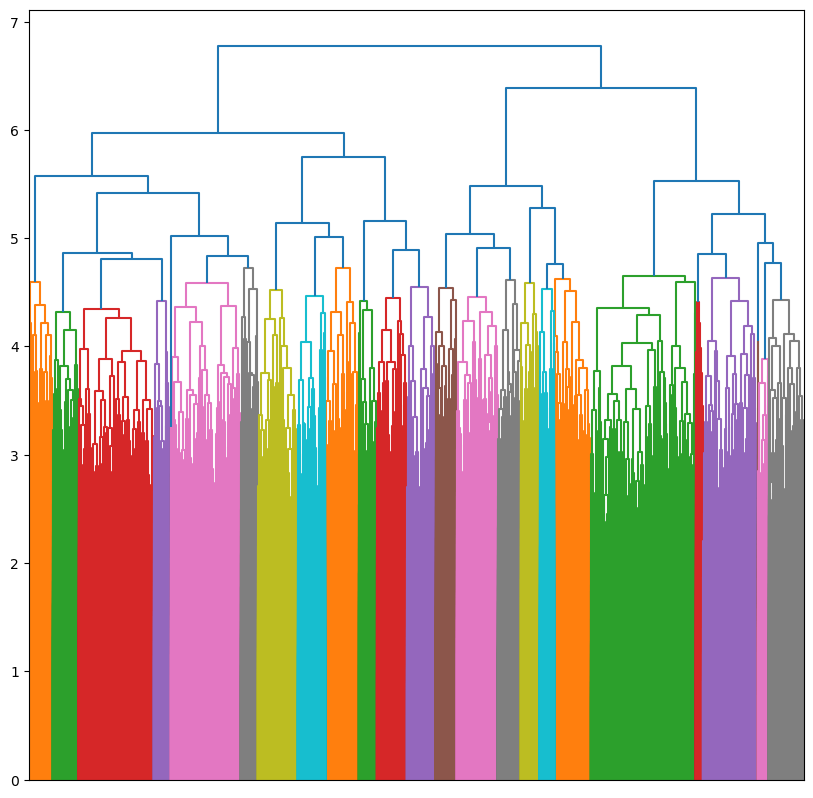

In [660]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax, no_labels=True)

In [661]:
final_cutoff = 5

In [662]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
# clusters_description = regional_ward_morphotopes_data.groupby(final_clusters).mean()
# clusters_description = grouped_data.groupby(final_clusters).mean()
final_clusters.value_counts()

2     11304
14    10025
4      8332
11     6140
15     5927
9      5572
13     4949
16     4382
5      3824
7      3244
6      2609
1      2347
10     2051
12     1775
8      1734
3         4
Name: count, dtype: int64

### Plotting

In [193]:

from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [255,255,255]

In [647]:
region_id = 69333 

region_id = 8707
# region_id = 5883
# region_id = 86873
# region_id = 38679
# region_id = 55763
# region_id = 107131
# region_id = 99886

# region_id = 151676

In [648]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)

In [652]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
# etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")


In [ ]:
# ## can run this to change colors on an exisitng layer
# layer.get_fill_color = get_color(etcs.final)

In [653]:




etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [654]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 2.2 s, sys: 298 ms, total: 2.5 s
Wall time: 2.5 s


In [655]:
from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters - {final_cutoff}')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

In [537]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.final].values.astype('uint8')

In [656]:
colorcodes = etcs['regional'].map(merged_clusters.to_dict()).fillna(-1)
layer.get_fill_color = merged_colors.loc[colorcodes].values.astype('uint8')
colorcodes.nunique()

24

In [539]:
etcs.final.value_counts().shape

(16,)

### Interactive dendro

In [156]:
from core import interactive_dendrogram
import jscatter
import ipywidgets

scatter_df = interactive_dendrogram.get_dendrogram_scatter_data(linkage_matrix)

def get_subcluster_children(focus):
    child, parent = linkage_matrix[focus - n, 0].astype(int), linkage_matrix[focus - n, 1].astype(int)
    children_ids = interactive_dendrogram.get_children(linkage_matrix, child, parent)
    children_morphotopes = regional_ward_morphotopes_data.iloc[children_ids].index
    return children_morphotopes

click_history = dict()
click_history_descriptions = dict()

In [ ]:
scatter = jscatter.Scatter(data=scatter_df, x='x', y='y', height=640, width=1280)
scatter.axes(grid=True)
scatter.connect(by='group1', order='order1')

# output = ipywidgets.Output()

# @output.capture(clear_output=True)
# def selection_change_handler(change):
#     display(scatter_df.loc[change.new].style.hide(axis='index'))
            
# scatter.widget.observe(selection_change_handler, names=["selection"])

# ipywidgets.HBox([scatter.show(), output])

In [157]:
scatter.show()

In [667]:
selected_node = scatter.selection()[0]

n = linkage_matrix.shape[0] + 1

left = scatter_df.loc[selected_node, 'child'].astype(int)
right = scatter_df.loc[selected_node, 'parent'].astype(int)

left_children = get_subcluster_children(left)
right_children = get_subcluster_children(right)

cluster_colors = np.full((etcs.shape[0], 3), 0) # everything black
cluster_colors[etcs.regional.isin(left_children)] = [141,211,199] # left blue - 1
cluster_colors[etcs.regional.isin(right_children)] = [255,255,179] # right yellow - 2
layer.get_fill_color = cluster_colors.astype('uint8')

In [668]:
left_data = regional_ward_morphotopes_data.loc[left_children].mean()
right_data = regional_ward_morphotopes_data.loc[right_children].mean()
# assert np.isclose(pd.DataFrame({1:left_data, 2: right_data}).T.values, clusters_description.values).all()

diffs = (left_data - right_data)
diffs = diffs[(diffs ** 2).sort_values(ascending=False).index].head(20)
diffs

linWID   -0.353319
ldsMSL    0.326509
lddNDe   -0.313106
linP4W   -0.284476
sdsSWD    0.282017
lcdMes   -0.280881
sdsAre    0.258535
stbSAl    0.248115
ldsCDL    0.246362
ldsAre    0.241463
sddAre    0.239292
linPDE    0.238522
sssLin   -0.237544
ltcWRB   -0.233164
midAre    0.225643
ssbERI    0.222684
ssbCor   -0.220038
mtdMDi    0.218669
sdsLen    0.206748
ssbCCD   -0.199874
dtype: float64

In [669]:
selected_node

np.uint32(113183)

In [670]:
used_keys['lddNDe']

'local node density of street network'

In [671]:
## save for cutting...
click_history[selected_node] = diffs

In [672]:
click_history_descriptions[selected_node] = 'frankfurt adjacent industry'

In [673]:
## assign clusters

In [674]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)

grouping = pd.DataFrame()
grouping[final_cutoff] = final_clusters.astype(str)

In [675]:
# for selected_node in [6421, 6887, 28557, 15017, 35908]: - hierarchy without lithuania


for selected_node in click_history.keys():
    left = scatter_df.loc[selected_node, 'child'].astype(int)
    right = scatter_df.loc[selected_node, 'parent'].astype(int)
    
    left_children = get_subcluster_children(left)
    right_children = get_subcluster_children(right)
    
    grouping.loc[left_children, round(scatter_df.loc[selected_node, 'dist'], 2)] = str(selected_node) + '1'
    grouping.loc[right_children, round(scatter_df.loc[selected_node, 'dist'], 2)] = str(selected_node) + '2'

click_history.keys()

dict_keys([np.uint32(111423), np.uint32(33393), np.uint32(38449), np.uint32(37855), np.uint32(148429), np.uint32(72344), np.uint32(146708), np.uint32(121375), np.uint32(47156), np.uint32(63627), np.uint32(113183)])

In [676]:
ordered_columns = grouping.columns.sort_values()
grouping = grouping[ordered_columns]

# forward cluster breakdowns to higher levels
for i, col in enumerate(ordered_columns[:-1]):
    grouping.iloc[grouping[col].notna().values, i + 1] = grouping.loc[grouping[col].notna(), col]  

In [677]:
merged_clusters = grouping[final_cutoff]
merged_clusters = pd.Series(merged_clusters.factorize()[0], merged_clusters.index)

In [678]:
merged_colors = pd.DataFrame(get_color(merged_clusters.values), merged_clusters.values).drop_duplicates()
merged_colors.loc[-1] = [255,255,255]

In [679]:
colorcodes = etcs['regional'].map(merged_clusters.to_dict()).fillna(-1)
layer.get_fill_color = merged_colors.loc[colorcodes].values.astype('uint8')

In [680]:
click_history.keys()

dict_keys([np.uint32(111423), np.uint32(33393), np.uint32(38449), np.uint32(37855), np.uint32(148429), np.uint32(72344), np.uint32(146708), np.uint32(121375), np.uint32(47156), np.uint32(63627), np.uint32(113183)])

In [681]:
click_history_descriptions

{np.uint32(111423): 'freiburg old centre',
 np.uint32(33393): 'freiburg small industry',
 np.uint32(38449): 'prague historicals',
 np.uint32(37855): 'prague vinohrady',
 np.uint32(148429): 'prague big industry',
 np.uint32(146596): 'prague smaller industry',
 np.uint32(72344): 'prague smallest industry',
 np.uint32(146708): 'bratislava small industry',
 np.uint32(121375): 'vienna houses and small industry',
 np.uint32(47156): 'vienna houses and small industry',
 np.uint32(63627): 'vienna houses and small industry',
 np.uint32(113183): 'frankfurt adjacent industry'}

In [682]:
scatter_df.loc[click_history_descriptions.keys()]

,child,parent,dist,size,x,y,group1,order1
111423,142104.0,145600.0,2.604807,188.0,7.417605e+05,2.604807,73268.0,3
33393,148212.0,148264.0,4.341564,1558.0,6.490147e+05,4.341564,74170.0,1
38449,147648.0,148172.0,3.790940,919.0,7.564160e+05,3.790940,74152.0,3
37855,146988.0,147122.0,3.056914,223.0,7.556015e+05,3.056914,73953.0,3
148429,148338.0,148345.0,4.427767,3316.0,1.440669e+06,4.427767,74195.0,1
146596,124438.0,126388.0,1.690406,61.0,1.447183e+06,1.690406,58738.0,2
72344,112898.0,114828.0,1.468394,27.0,1.446894e+06,1.468394,50219.0,2
146708,145101.0,145293.0,2.682737,297.0,1.445452e+06,2.682737,73080.0,1
121375,148395.0,148407.0,4.907557,6140.0,8.909151e+05,4.907557,74205.0,1
47156,148353.0,148386.0,4.611616,2234.0,9.226107e+05,4.611616,74201.0,1


In [683]:
merged_clusters.nunique()

35

In [685]:
merged_clusters.to_frame().to_parquet('../data/clusters_v1.pq')

## hierarchy of final clusters

In [ ]:
fdata = grouped_data.groupby(merged_clusters).median().fillna(0)


In [707]:
fdata.to_parquet('../data/cluster_data.pq')


In [600]:
fdata = grouped_data.groupby(merged_clusters).median().fillna(0)
scalar = StandardScaler()
vals = scalar.fit_transform(fdata)
fdata = pd.DataFrame(vals, index=fdata.index, columns=fdata.columns)

In [601]:
linkage = 'complete'
metric = 'euclidean'
linkage_matrix = get_morphotope_linkage(fdata)

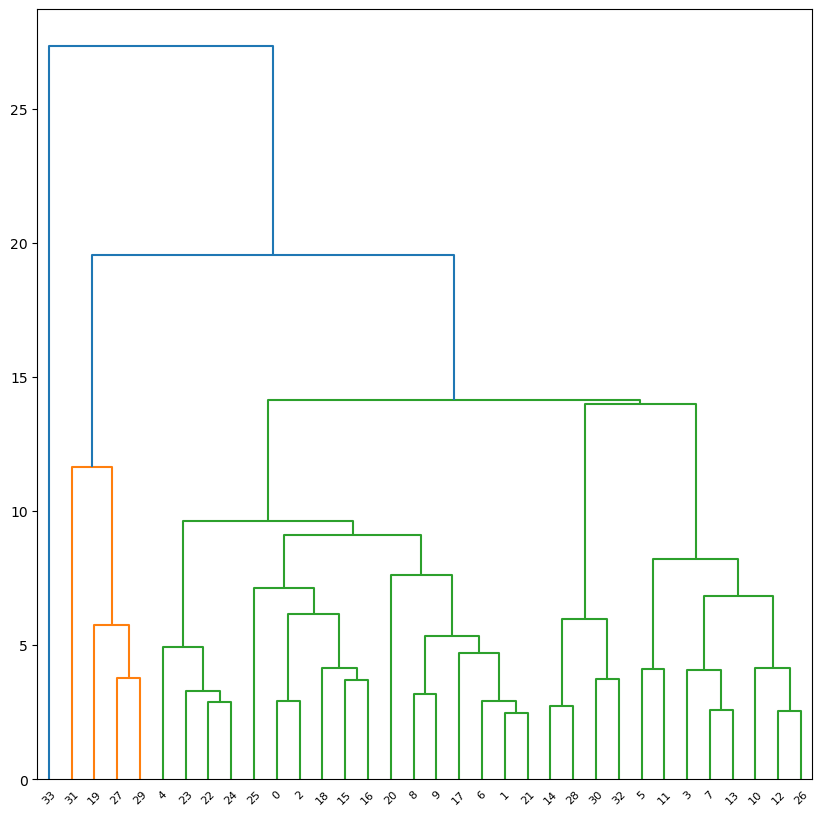

In [602]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax)

In [622]:
etcs[etcs.final == 28].explore(prefer_canvas=True, tiles='cartodb.positron')

In [574]:
final_cutoff = 8
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, fdata.index)
final_clusters.value_counts()

5    7
4    6
8    6
3    4
6    4
1    3
7    2
2    1
9    1
Name: count, dtype: int64

In [770]:
region_hulls.explore()

## assign to etcs

In [697]:
merged_colors = pd.DataFrame(get_color(merged_clusters.values), merged_clusters.values).drop_duplicates()
merged_colors.loc[-1] = [255,255,255]

In [781]:
region_id = 69333

In [782]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)
etcs.shape

(437045, 7)

In [783]:
# region_hulls.explore()

In [784]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: merged_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")

In [785]:
# etcs['final'] = etcs.final.map(final_clusters).values

In [786]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters - {final_cutoff}')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = merged_colors.loc[etcs.final].values.astype('uint8')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 2.32 s, sys: 209 ms, total: 2.53 s
Wall time: 2.51 s


In [777]:
# layer.get_fill_color = get_color(etcs.final.map(final_clusters).values.astype(int))

In [778]:
etcs.final.nunique()

23

In [780]:
etcs.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/{region_id}_clusters.pq')

In [779]:
merged_colors.shape

(36, 3)

### Tree comparisons

In [224]:
from sklearn.neighbors import KDTree

In [225]:
tree = KDTree(regional_ward_morphotopes_data.values)

In [527]:
dists, idxs = tree.query(regional_ward_morphotopes_data.loc[['69333_66']], k=100)

In [528]:
regional_ward_morphotopes_data.iloc[idxs[0]].index

Index(['69333_66', '62954_18', '114311_66', '35141_1', '97745_5', '78792_11',
       '1154_19', '109491_60', '105385_4', '107131_445', '97745_3',
       '105090_15', '78938_32', '93793_17', '72396_10', '61183_2', '116866_31',
       '107131_447', '86873_39', '67156_11', '62954_16', '83538_29',
       '80404_68', '18557_91', '51289_3', '130658_17', '64220_42', '75642_5',
       '62193_4', '90196_6', '87947_3', '93167_16', '73611_9', '107131_441',
       '114311_65', '84554_38', '108884_27', '1154_18', '61187_17',
       '109491_63', '110908_2', '103561_13', '107131_456', '90770_55',
       '67803_4', '93504_7', '82514_3', '120961_8', '114311_64', '78938_31',
       '53525_2', '86863_4', '116866_32', '97745_6', '90075_1', '93793_10',
       '103713_6', '88950_2', '96465_1', '97978_10', '84962_7', '128286_16',
       '93167_15', '109491_59', '80313_11', '102814_9', '84420_6', '55763_24',
       '85156_4', '89921_2', '72507_21', '76038_20', '129730_34', '82773_14',
       '96727_11', '7547

In [139]:
# etcs[etcs.regional == '69333_64'].explore()